# Loan Default Prediction

In [101]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [102]:
# import datasets

accepted_raw = pd.read_csv(
    r"E:\Loan\accepted_2007_to_2018q4.csv\accepted_2007_to_2018Q4.csv",
)

rejected_raw = pd.read_csv(
    r"E:\Loan\rejected_2007_to_2018q4.csv\rejected_2007_to_2018Q4.csv",
)

In [103]:
#Number of rows and columns

print(accepted_raw.shape)
print(rejected_raw.shape)

(2260701, 151)
(27648741, 9)


In [104]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
accepted_raw.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

# Data Preparation

In [105]:
accepted_raw['loan_status'].value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

Only consider loans that are either Fully Paid or Charged Off.

In [106]:
accepted = accepted_raw[
    accepted_raw["loan_status"].isin(["Fully Paid", "Charged Off"])
].copy()

In [134]:
accepted.loc[:, "default_flag"] = (
    accepted["loan_status"] == "Charged Off"
).astype(int)

In [108]:
accepted['loan_status'].value_counts(normalize=True, dropna=False)

loan_status
Fully Paid     0.800374
Charged Off    0.199626
Name: proportion, dtype: float64

In [109]:
# Sorted the number of missing values of features
missing_fractions = accepted.isnull().sum().sort_values(ascending=False)
missing_fractions

member_id                                     1345310
next_pymnt_d                                  1345310
orig_projected_additional_accrued_interest    1341551
hardship_amount                               1339556
hardship_last_payment_amount                  1339556
hardship_length                               1339556
hardship_status                               1339556
hardship_reason                               1339556
deferral_term                                 1339556
hardship_start_date                           1339556
hardship_end_date                             1339556
hardship_type                                 1339556
hardship_loan_status                          1339556
hardship_payoff_balance_amount                1339556
hardship_dpd                                  1339556
payment_plan_start_date                       1339556
sec_app_mths_since_last_major_derog           1338665
sec_app_revol_util                            1327008
revol_bal_joint             

In [110]:
# Remove features having over 1,000,000 missing entries
drop_list = sorted(list(missing_fractions[missing_fractions > 1000000].index))
print('Drop_list len:',len(drop_list))
print(drop_list)

Drop_list len: 41
['annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'member_id', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'next_pymnt_d', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util', 'settlement_amount', 'settlement_date', 'settlement_percentage', 'settlement_status', 'settlement_term', 'verification_status_joint']


In [111]:
# Drop features having over 1,000,000 missing entries
accepted.drop(labels=drop_list, axis=1, inplace=True)
accepted.shape

(1345310, 111)

In [112]:
print(sorted(accepted.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'default_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'il_util', 'initial_list_status', 'inq_fi', 'inq_last_12m', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_inq', 'mths_sin

In [113]:
# Required columns

needed_cols = ['charged_off','funded_amnt','addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 
             'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 
             'installment', 'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 
             'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code',
             'last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op',"bc_util","bc_open_to_buy","avg_cur_bal","acc_open_past_24mths" ]
len(needed_cols)

40

In [114]:
drop_list = [col for col in accepted.columns if col not in needed_cols]

In [115]:
accepted.drop(labels=drop_list, axis=1, inplace=True)
accepted.shape

(1345310, 39)

# Explore

In [116]:
# Basic Info
accepted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1345310 entries, 0 to 2260697
Data columns (total 39 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   id                     1345310 non-null  object 
 1   loan_amnt              1345310 non-null  float64
 2   funded_amnt            1345310 non-null  float64
 3   term                   1345310 non-null  object 
 4   int_rate               1345310 non-null  float64
 5   installment            1345310 non-null  float64
 6   grade                  1345310 non-null  object 
 7   sub_grade              1345310 non-null  object 
 8   emp_title              1259525 non-null  object 
 9   emp_length             1266799 non-null  object 
 10  home_ownership         1345310 non-null  object 
 11  annual_inc             1345310 non-null  float64
 12  verification_status    1345310 non-null  object 
 13  loan_status            1345310 non-null  object 
 14  purpose                

In [117]:
# Loan Applications Info

total_applications = len(accepted_raw) + len(rejected_raw)
approved_count = len(accepted_raw)
rejected_count = len(rejected_raw)
print("Total Applications:", total_applications)
print("Approval Count:", approved_count)
print("Rejection Count:", rejected_count)

Total Applications: 29909442
Approval Count: 2260701
Rejection Count: 27648741


### Overall Approval rate and Default rate?

In [118]:
# Approval rate

approval_rate = approved_count/total_applications
print(f"Approved loans: {approved_count:,}")
print(f"Approval rate: {approval_rate:.2%}")

Approved loans: 2,260,701
Approval rate: 7.56%


In [119]:
# Default rate

default_status = ["Charged Off"]

default_count = accepted[
    accepted["loan_status"].isin(default_status)
].shape[0]

default_rate = default_count / approved_count

print(f"Defaulted loans: {default_count:,}")
print(f"Default rate: {default_rate:.2%}")

Defaulted loans: 268,559
Default rate: 11.88%


The dataset contains approximately 28.9 million loan applications, of which 2.26 million were approved, resulting in an overall approval rate of 7.56%. This indicates a highly selective lending strategy. Among approved loans, 11.88% resulted in serious delinquency or charge-off, establishing a baseline default rate for the portfolio. Despite strict approval criteria, a meaningful proportion of approved loans still default, highlighting the importance of further risk differentiation and model-based decisioning.

### Loan Status

In [120]:
accepted['loan_status'].value_counts().hvplot.bar(
    title="Loan Status Counts", xlabel='Loan Status', ylabel='Count', 
    width=500, height=350
)

:Bars   [loan_status]   (count)

### Loan Status by Grade and Sub-Grage

In [121]:
print(f"GRADE unique: {accepted.grade.unique()}")
print(f"SUB_GRADE unique: {accepted.sub_grade.unique()}")

GRADE unique: ['C' 'B' 'F' 'A' 'E' 'D' 'G']
SUB_GRADE unique: ['C4' 'C1' 'B4' 'F1' 'C3' 'B2' 'B1' 'A2' 'B5' 'C2' 'E2' 'A4' 'E3' 'C5'
 'A1' 'D4' 'F3' 'D1' 'B3' 'D3' 'D5' 'A5' 'F2' 'E4' 'D2' 'E1' 'F5' 'E5'
 'A3' 'G2' 'G1' 'G3' 'G4' 'F4' 'G5']


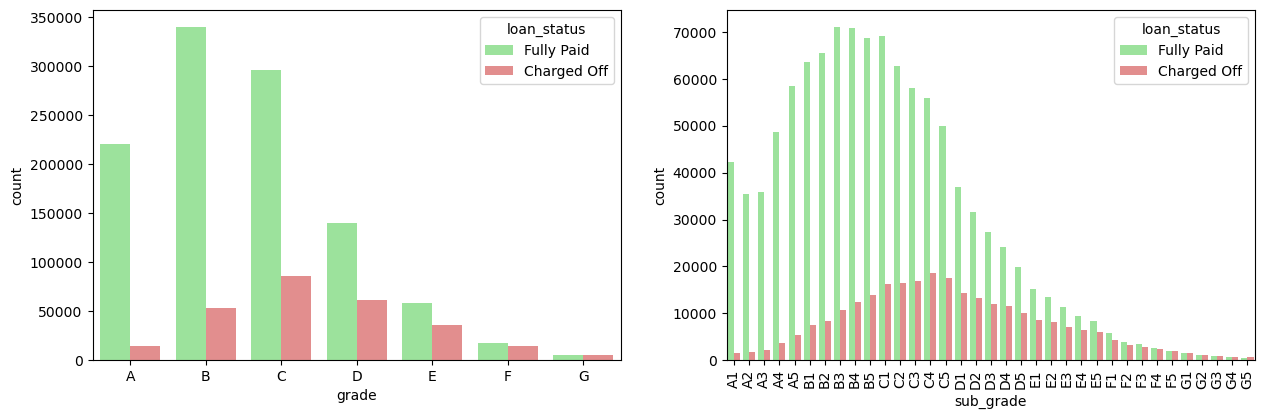

In [122]:
palette = {
    'Fully Paid': 'lightgreen',
    'Charged Off': 'lightcoral'
}

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(accepted.grade.unique().tolist())
sns.countplot(x='grade', data=accepted, hue='loan_status', order=grade, palette = palette)

plt.subplot(2, 2, 2)
sub_grade = sorted(accepted.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=accepted, hue='loan_status', order=sub_grade, palette = palette)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

### Loan Status by Home Ownership, Verification_status, Term

In [123]:
accepted['home_ownership'].value_counts()

home_ownership
MORTGAGE    665579
RENT        534421
OWN         144832
ANY            286
OTHER          144
NONE            48
Name: count, dtype: int64

In [124]:
accepted.loc[(accepted.home_ownership == 'ANY') | (accepted.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'  
accepted["home_ownership"].value_counts()

home_ownership
MORTGAGE    665579
RENT        534421
OWN         144832
OTHER          478
Name: count, dtype: int64

In [125]:
accepted['term'].value_counts()

term
36 months    1020743
60 months     324567
Name: count, dtype: int64

In [126]:
accepted['verification_status'].value_counts()

verification_status
Source Verified    521273
Verified           418336
Not Verified       405701
Name: count, dtype: int64

In [127]:
accepted['purpose'].value_counts()

purpose
debt_consolidation    780321
credit_card           295279
home_improvement       87504
other                  77875
major_purchase         29425
medical                15554
small_business         15416
car                    14585
moving                  9480
vacation                9065
house                   7253
wedding                 2294
renewable_energy         933
educational              326
Name: count, dtype: int64

<Axes: xlabel='verification_status', ylabel='count'>

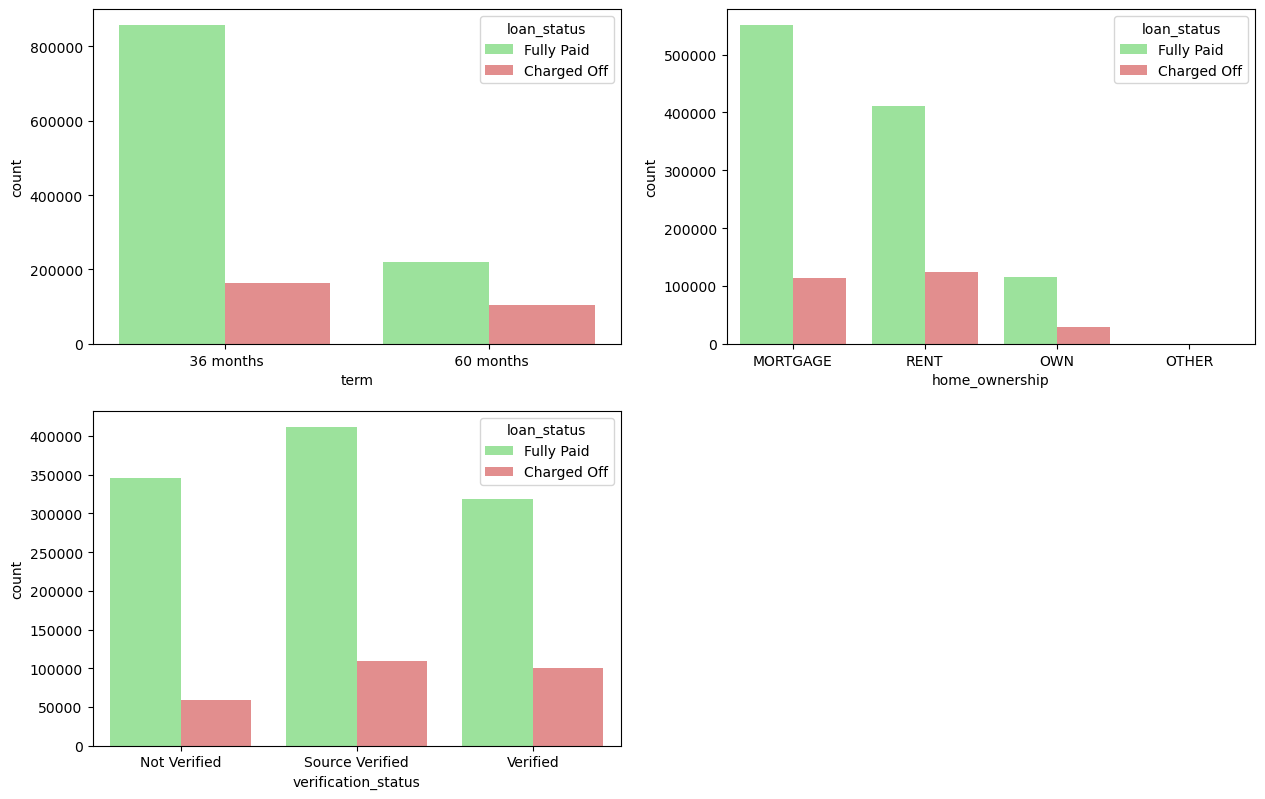

In [128]:
palette = {
    'Fully Paid': 'lightgreen',
    'Charged Off': 'lightcoral'
}

plt.figure(figsize=(15, 20))

plt.subplot(4, 2, 1)
sns.countplot(x='term', data=accepted, hue='loan_status', palette=palette)

plt.subplot(4, 2, 2)
sns.countplot(x='home_ownership', data=accepted, hue='loan_status', palette=palette)

plt.subplot(4, 2, 3)
sns.countplot(x='verification_status', data=accepted, hue='loan_status', palette=palette)

### Loan Status by Employee Length

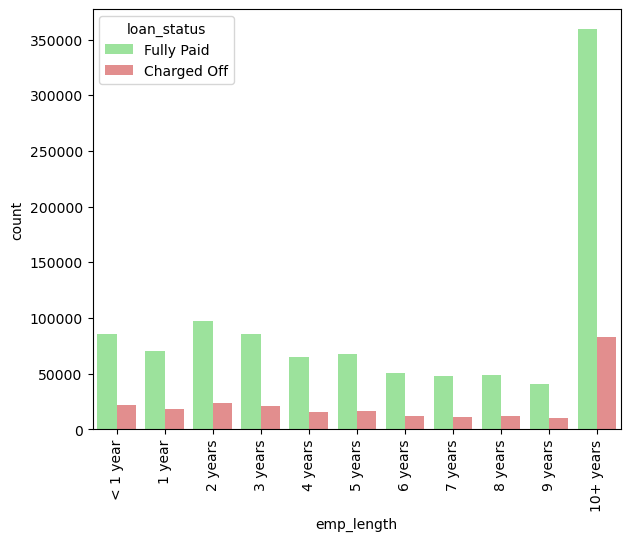

In [129]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
g = sns.countplot(x='emp_length', data=accepted, hue='loan_status', order=order, palette= palette)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

### Loan Status by pub_rec, initial_list_status, application_type, mort_acc, pub_rec_bankruptcies

In [130]:
def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1
    
def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number
    
def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

In [131]:
accepted['pub_rec'] = accepted.pub_rec.apply(pub_rec)
accepted['mort_acc'] = accepted.mort_acc.apply(mort_acc)
accepted['pub_rec_bankruptcies'] = accepted.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

<Axes: xlabel='pub_rec_bankruptcies', ylabel='count'>

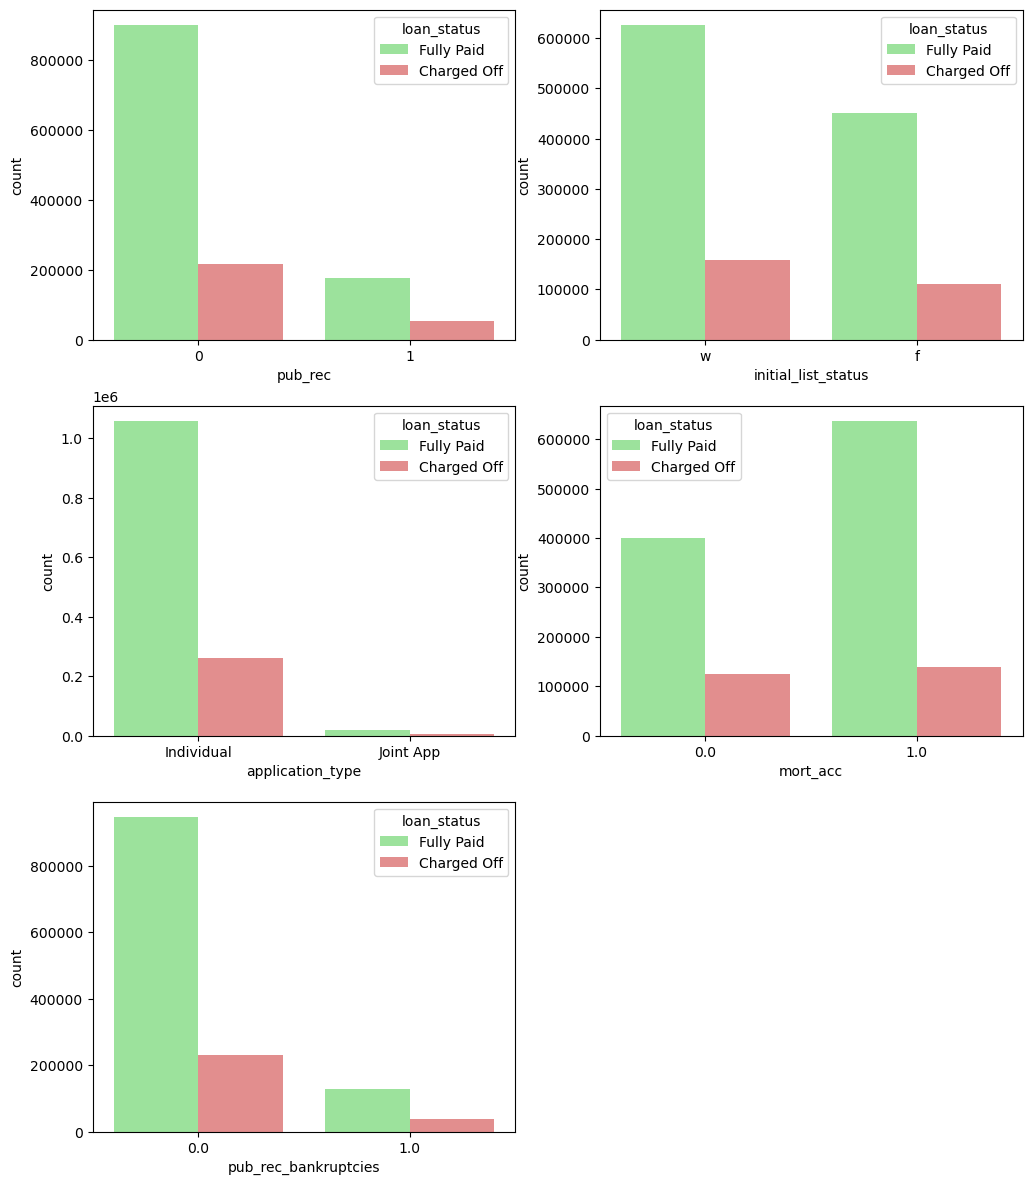

In [132]:
plt.figure(figsize=(12, 30))

plt.subplot(6, 2, 1)
sns.countplot(x='pub_rec', data=accepted, hue='loan_status', palette=palette)

plt.subplot(6, 2, 2)
sns.countplot(x='initial_list_status', data=accepted, hue='loan_status', palette=palette)

plt.subplot(6, 2, 3)
sns.countplot(x='application_type', data=accepted, hue='loan_status', palette=palette)

plt.subplot(6, 2, 4)
sns.countplot(x='mort_acc', data=accepted, hue='loan_status', palette=palette)

plt.subplot(6, 2, 5)
sns.countplot(x='pub_rec_bankruptcies', data=accepted, hue='loan_status', palette=palette)

### Default rate by Loan Purpose, Fico Band, Dti, Income Band

In [135]:
# Default Rate by Loan Purpose

default_by_purpose = (
    accepted
    .groupby("purpose", observed=True)
    .agg(
        approved_loans=("default_flag", "count"),
        defaulted_loans=("default_flag", "sum")
    )
    
)

default_by_purpose["default_rate"] = (
    default_by_purpose["defaulted_loans"] /
    default_by_purpose["approved_loans"] * 100
).round(2).astype(str) + "%"

default_by_purpose = default_by_purpose.sort_values(
    "default_rate", ascending=False
)

default_by_purpose.reset_index()

,purpose,approved_loans,defaulted_loans,default_rate
0,small_business,15416,4580,29.71%
1,renewable_energy,933,221,23.69%
2,moving,9480,2214,23.35%
3,house,7253,1587,21.88%
4,medical,15554,3387,21.78%
5,debt_consolidation,780321,165014,21.15%
6,other,77875,16385,21.04%
7,vacation,9065,1738,19.17%
8,major_purchase,29425,5473,18.6%
9,home_improvement,87504,15502,17.72%


In [136]:
accepted["fico_avg"] = (
    accepted["fico_range_low"] +
    accepted["fico_range_high"]
) / 2

In [137]:
# Default rate by FICO band

# Create FICO bands
fico_bins = [300, 580, 620, 660, 700, 740, 850]
fico_labels = [
    "Very Poor", "Poor", "Fair",
    "Good", "Very Good", "Excellent"
]
accepted["fico_band"] = pd.cut(
    accepted["fico_avg"],
    bins=fico_bins,
    labels=fico_labels,
    right=False
)

# Default rate by FICO band
default_by_fico = (
    accepted
    .groupby("fico_band", observed=True)
    .agg(
        approved_loans=("default_flag", "count"),
        defaulted_loans=("default_flag", "sum")
    )
    .reset_index()
)
default_by_fico["default_rate"] = (
    (default_by_fico["defaulted_loans"] /
    default_by_fico["approved_loans"]) * 100
).round(2).astype(str) + "%"

default_by_fico

,fico_band,approved_loans,defaulted_loans,default_rate
0,Fair,2,0,0.0%
1,Good,820804,193634,23.59%
2,Very Good,379208,60900,16.06%
3,Excellent,145296,14025,9.65%


In [138]:
# Default rate by DTI band

# Create DTI bands
dti_bins = [0, 10, 20, 30, 40, 100]
dti_labels = ["Very Low", "Low", "Medium", "High", "Very High"]

accepted["dti_band"] = pd.cut(
    accepted["dti"],
    bins=dti_bins,
    labels=dti_labels,
    right=False
)

# Default rate by DTI band
default_by_dti = (
    accepted
    .groupby("dti_band", observed=True)
    .agg(
        approved_loans=("default_flag", "count"),
        defaulted_loans=("default_flag", "sum")
    )
    .reset_index()
)
default_by_dti["default_rate"] = (
    (default_by_dti["defaulted_loans"] /
    default_by_dti["approved_loans"]) * 100
).round(2).astype(str) + "%"

default_by_dti

,dti_band,approved_loans,defaulted_loans,default_rate
0,Very Low,245712,36574,14.88%
1,Low,561904,100224,17.84%
2,Medium,408641,94163,23.04%
3,High,121907,35459,29.09%
4,Very High,6235,1925,30.87%


In [139]:
# Default rate by income band

# Create income bands
income_bins = [0, 30000, 60000, 100000, 200000, accepted["annual_inc"].max()]
income_labels = [
    "Low Income", "Lower-Mid",
    "Upper-Mid", "High", "Very High"
]
accepted["income_band"] = pd.cut(
    accepted["annual_inc"],
    bins=income_bins,
    labels=income_labels,
    right=False
)

# Default rate by income band
default_by_income = (
    accepted
    .groupby("income_band", observed=True)
    .agg(
        approved_loans=("default_flag", "count"),
        defaulted_loans=("default_flag", "sum")
    )
    .reset_index()
)
default_by_income["default_rate"] = (
    (default_by_income["defaulted_loans"] /
    default_by_income["approved_loans"]) * 100
).round(2).astype(str) + "%"

default_by_income

,income_band,approved_loans,defaulted_loans,default_rate
0,Low Income,78509,19117,24.35%
1,Lower-Mid,487397,107945,22.15%
2,Upper-Mid,502469,97428,19.39%
3,High,243657,39407,16.17%
4,Very High,33277,4662,14.01%


# Data PreProcessing

In [140]:
accepted.drop(labels=['fico_range_high', 'fico_range_low',"income_band", "dti_band", "fico_band"], axis=1, inplace=True)

In [141]:
corr = accepted.corr(numeric_only=True)

corr_default = abs(corr['default_flag']).sort_values(ascending=False)
corr_default

default_flag             1.000000
last_pymnt_amnt          0.347385
int_rate                 0.258792
fico_avg                 0.130683
acc_open_past_24mths     0.099869
dti                      0.084510
bc_open_to_buy           0.082044
avg_cur_bal              0.078924
mort_acc                 0.071124
num_actv_rev_tl          0.070814
bc_util                  0.066152
funded_amnt              0.065658
loan_amnt                0.065604
revol_util               0.060048
mo_sin_rcnt_rev_tl_op    0.053937
installment              0.051701
mo_sin_old_rev_tl_op     0.050502
annual_inc               0.041759
pub_rec                  0.031542
open_acc                 0.028078
pub_rec_bankruptcies     0.025371
revol_bal                0.020010
total_acc                0.011300
Name: default_flag, dtype: float64

In [142]:
# Drop features with < 0.03 in corr with label.
accepted = accepted.drop(columns=corr_default[corr_default < 0.03].index)

In [143]:
print(accepted['emp_title'].nunique())
print(accepted['title'].nunique())
print(accepted['zip_code'].nunique())

378353
61681
943


In [144]:
# Remove ['id','emp_title','title','zip_code'] because they have many unique values
accepted.drop(labels=['emp_title','title','zip_code'], axis=1, inplace=True)

In [145]:
accepted.drop(labels=['id'], axis=1, inplace=True)

In [146]:
# Check 'term' unique
accepted['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [147]:
# Conver 'term' into integer
term_values = {' 36 months': 36, ' 60 months': 60}
accepted['term'] = accepted.term.map(term_values)

In [148]:
for year in accepted.emp_length.unique():
    print(f"{year} years in this position:")
    print(f"{accepted[accepted.emp_length == year].loan_status.value_counts(normalize=True)}")
    print('==========================================')

10+ years years in this position:
loan_status
Fully Paid     0.812173
Charged Off    0.187827
Name: proportion, dtype: float64
3 years years in this position:
loan_status
Fully Paid     0.80031
Charged Off    0.19969
Name: proportion, dtype: float64
4 years years in this position:
loan_status
Fully Paid     0.802622
Charged Off    0.197378
Name: proportion, dtype: float64
6 years years in this position:
loan_status
Fully Paid     0.806481
Charged Off    0.193519
Name: proportion, dtype: float64
7 years years in this position:
loan_status
Fully Paid     0.805112
Charged Off    0.194888
Name: proportion, dtype: float64
8 years years in this position:
loan_status
Fully Paid     0.800662
Charged Off    0.199338
Name: proportion, dtype: float64
2 years years in this position:
loan_status
Fully Paid     0.801927
Charged Off    0.198073
Name: proportion, dtype: float64
5 years years in this position:
loan_status
Fully Paid     0.80399
Charged Off    0.19601
Name: proportion, dtype: float64
9 

Charge off rates are extremely similar across all employment lengths. So we are going to drop the emp_length column.

In [149]:
accepted.drop(labels=['emp_length'], axis=1, inplace=True)

In [150]:
# Month of the borrower’s earliest reported credit line opening
accepted['earliest_cr_line'].unique()
accepted['earliest_cr_line'] = accepted['earliest_cr_line'].apply(lambda s: int(s[-4:]))

         annual_inc
count  1.345310e+06
mean   7.624764e+04
std    6.992510e+04
min    0.000000e+00
25%    4.578000e+04
50%    6.500000e+04
75%    9.000000e+04
max    1.099920e+07


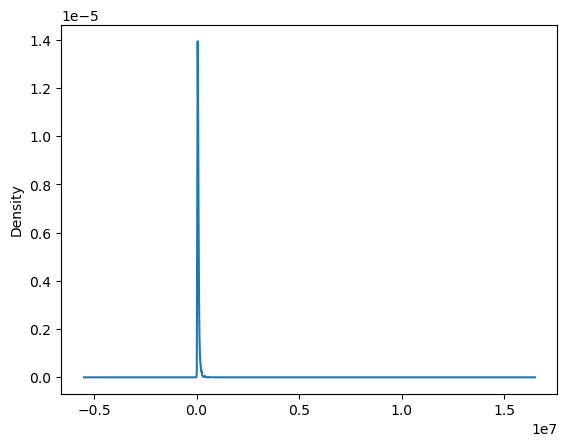

In [151]:
print(accepted[['annual_inc']].describe())

accepted['annual_inc'].plot.density()
plt.show()


It spans a wide range from 0 to 10,999,200, with a mean of 76,247 and a median of 65,000.

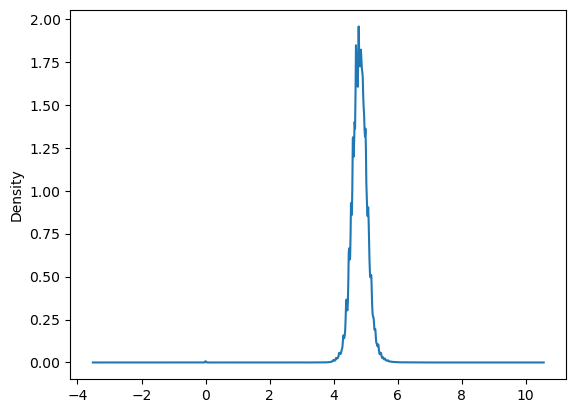

In [152]:
# Take a log transform 'annual_inc'
accepted['log_annual_inc'] = accepted['annual_inc'].apply(lambda x:np.log10(1+x))

accepted['log_annual_inc'].plot.density()
plt.show()

In [153]:
accepted.drop(labels=['annual_inc'], axis=1, inplace=True)

In [154]:
# Drop loan_status
accepted.drop(labels=['loan_status'], axis=1, inplace=True)

In [155]:
accepted.drop(labels=['funded_amnt'], axis=1, inplace=True)

In [156]:
# loan amount to installment ratio
accepted['loan_amnt_div_instlmnt']=accepted['loan_amnt']/accepted['installment']

In [157]:
accepted.drop(labels=['installment'], axis=1, inplace=True)

In [158]:
# Take categorical columns
categorical_feature_mask = accepted.dtypes==object
categorical_cols = accepted.columns[categorical_feature_mask].tolist()
categorical_cols

['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type']

In [159]:
# Apply LabelEncoders
accepted[categorical_cols] = accepted[categorical_cols].apply(lambda cols: LabelEncoder().fit_transform(cols))

In [160]:
accepted.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'home_ownership',
       'verification_status', 'purpose', 'addr_state', 'dti',
       'earliest_cr_line', 'pub_rec', 'revol_util', 'initial_list_status',
       'last_pymnt_amnt', 'application_type', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'num_actv_rev_tl', 'default_flag',
       'fico_avg', 'log_annual_inc', 'loan_amnt_div_instlmnt'],
      dtype='object')

# Predictive Analysis

In [161]:
# Set number of sampling
n_sampling = 10000

loanstatus_0 = accepted[accepted["default_flag"]==0]
loanstatus_1 = accepted[accepted["default_flag"]==1]

subset_loanstatus_0 = loanstatus_0.sample(n=n_sampling, random_state=42)
subset_loanstatus_1 = loanstatus_1.sample(n=n_sampling, random_state=42)

print('subset_loanstatus_0:', subset_loanstatus_0.shape)
print('subset_loanstatus_1:', subset_loanstatus_1.shape)

subset_loanstatus_0: (10000, 28)
subset_loanstatus_1: (10000, 28)


In [162]:
# New balanced dataset
dataset_sampling = pd.concat([subset_loanstatus_1, subset_loanstatus_0])

# Shuffle balanced dataset
dataset_sampling = dataset_sampling.sample(frac=1, random_state=42).reset_index(drop=True)

print ('dataset_sampling shape:', dataset_sampling.shape)
dataset_sampling[:5]

dataset_sampling shape: (20000, 28)


,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,dti,earliest_cr_line,pub_rec,revol_util,initial_list_status,last_pymnt_amnt,application_type,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,default_flag,fico_avg,log_annual_inc,loan_amnt_div_instlmnt
0,12000.0,60,16.29,3,16,0,0,2,3,36.35,1993,0,63.4,0,10727.74,0,9.0,13233.0,3432.0,83.7,260.0,7.0,1.0,9.0,0,687.0,4.748196,40.862192
1,13850.0,36,16.59,3,16,0,0,4,18,17.03,2006,0,36.0,0,490.97,0,13.0,2122.0,2614.0,42.0,45.0,3.0,0.0,11.0,1,687.0,4.792399,28.209463
2,35000.0,36,12.99,2,11,0,2,2,31,22.32,1989,1,36.6,1,1179.12,1,5.0,15228.0,7675.0,41.9,316.0,3.0,1.0,8.0,1,682.0,4.776745,29.683154
3,25000.0,60,14.30,2,10,0,2,2,1,19.23,1983,0,70.2,0,585.61,0,1.0,12819.0,2599.0,88.4,361.0,32.0,1.0,6.0,1,712.0,4.784196,42.690528
4,24250.0,60,11.49,1,8,0,2,2,45,23.17,1985,0,33.9,0,502.94,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,762.0,4.792399,45.480120


In [163]:
# Apply Mean of column to Na 
dataset_sampling.fillna(dataset_sampling.mean(),inplace = True)

In [164]:
Y = dataset_sampling['default_flag']
X = dataset_sampling.loc[:, dataset_sampling.columns != 'default_flag']

In [165]:
# Train/Test Split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=617)

In [166]:
# Model Evaluation Utility Function

def print_model_results(model, X, y, label="Train"):
    y_pred = model.predict(X)

    acc = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, output_dict=True)
    cm = confusion_matrix(y, y_pred)

    print(f"\n{label} Result:")
    print("=" * 48)
    print(f"Accuracy Score: {acc*100:.2f}%")
    print("_" * 47)
    print("CLASSIFICATION REPORT:")

    df_report = (
        pd.DataFrame(report)
        .T
        .round(2)
    )

    print(df_report)
    print("_" * 47)
    print("Confusion Matrix:")
    print(cm)

In [167]:
# Unified Grid Search and Model Evaluation Function

def run_gridsearch(
    model,
    param_grid,
    model_name,
    X_train,
    Y_train,
    X_test,
    Y_test,
    cv=3,
    scoring="roc_auc"
):
    print(f"\n{'='*60}")
    print(f"Running GridSearch for {model_name}")
    print(f"{'='*60}")

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        verbose=2
    )

    grid.fit(X_train, Y_train)

    print(f"\nBest {model_name} Params:", grid.best_params_)
    print(f"Best {model_name} CV AUC:", grid.best_score_)

    best_model = grid.best_estimator_

    print_model_results(best_model, X_train, Y_train, label="Train")
    print_model_results(best_model, X_test, Y_test, label="Test")

    return best_model, grid.best_score_


In [168]:
# Model Definitions and Hyperparameter Search Space

# Logistic Classifier
log_model = LogisticRegression(max_iter=10000, solver="lbfgs", n_jobs=-1)

param_grid_log = {
    "C": [0.01, 0.1, 1, 10]
}

# Random Forest Classifier
rf = RandomForestClassifier(random_state=1031)

param_grid_rf = {
    "n_estimators": [200, 300],
    "max_depth": [2, 3, 4],
    "min_samples_split": [2, 5]
}

# Gradientboost Classifier
gb = GradientBoostingClassifier(random_state=1031)

param_grid_gb = {
    "n_estimators": [300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3],
    "subsample": [0.7, 0.8, 1.0]
}

# XGBoost Classifier
xgb = XGBClassifier(
    eval_metric="auc",
    random_state=1031,
    n_jobs=-1
)

param_grid_xgb = {
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.7, 0.8]
}

In [169]:
# Model Training, Hyperparameter Tuning, and Evaluation

best_log, log_auc = run_gridsearch(
    log_model, param_grid_log,
    "Logistic Regression",
    X_train, Y_train, X_test, Y_test
)

best_rf, rf_auc = run_gridsearch(
    rf, param_grid_rf,
    "Random Forest",
    X_train, Y_train, X_test, Y_test
)

best_gb, gb_auc = run_gridsearch(
    gb, param_grid_gb,
    "Gradient Boosting",
    X_train, Y_train, X_test, Y_test
)

best_xgb, xgb_auc = run_gridsearch(
    xgb, param_grid_xgb,
    "XGBoost",
    X_train, Y_train, X_test, Y_test
)



Running GridSearch for Logistic Regression
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best Logistic Regression Params: {'C': 1}
Best Logistic Regression CV AUC: 0.9283328815914956

Train Result:
Accuracy Score: 86.02%
_______________________________________________
CLASSIFICATION REPORT:
              precision  recall  f1-score   support
0                  0.93    0.78      0.85   8000.00
1                  0.81    0.94      0.87   8000.00
accuracy           0.86    0.86      0.86      0.86
macro avg          0.87    0.86      0.86  16000.00
weighted avg       0.87    0.86      0.86  16000.00
_______________________________________________
Confusion Matrix:
[[6244 1756]
 [ 480 7520]]

Test Result:
Accuracy Score: 86.50%
_______________________________________________
CLASSIFICATION REPORT:
              precision  recall  f1-score  support
0                  0.94    0.78      0.85  2000.00
1                  0.81    0.95      0.88  2000.00
accuracy           0.86   

In [170]:
# Cross-Validated Model Performance Comparison

results = pd.DataFrame({
    "Model": ["Logistic", "Random Forest", "Gradient Boosting", "XGBoost"],
    "CV ROC-AUC": [log_auc, rf_auc, gb_auc, xgb_auc]
}).sort_values(by="CV ROC-AUC", ascending=False)

results


,Model,CV ROC-AUC
2,Gradient Boosting,0.947879
3,XGBoost,0.946705
0,Logistic,0.928333
1,Random Forest,0.922523


Among all evaluated models, Gradient Boosting achieved the highest cross-validated ROC-AUC (0.948) and the best test accuracy (88.06%) while maintaining a low train–test performance gap. Random Forest exhibited severe overfitting, achieving near-perfect training accuracy but significantly lower test performance. Logistic Regression served as a strong baseline but underperformed tree-based boosting models. Therefore, Gradient Boosting was selected as the final model due to its superior generalization and balanced performance.